In [2]:
import numpy as np
from scipy.integrate import odeint
from scipy import optimize
import pandas as pd
import matplotlib.pyplot as plt

data from 
1. Sondi, I. & Salopek-Sondi, B. Silver nanoparticles as antimicrobial agent: a case study on E. coli as a model for Gram-negative bacteria. Journal of Colloid and Interface Science 275, 177–182 (2004).
2. Lu, M. et al. Synergistic bactericidal activity of chlorhexidine-loaded, silver-decorated mesoporous silica nanoparticles. IJN 12, 3577–3589 (2017).

model from
1. Haque, M. A. et al. An experiment-based model quantifying antimicrobial activity of silver nanoparticles on Escherichia coli. RSC Adv. 7, 56173–56182 (2017).

In [3]:

ecoli = pd.read_csv('./ecoli.csv')
df_e = ecoli
saureus = pd.read_csv('./saureus.csv')
df_s = saureus
ecoli_od = pd.read_csv('./ecoli-od.csv')
df_eo = ecoli_od

In [4]:
def model_SAD(I,t,beta,k0,A,alpha):
    Na,Ns,Nd = I
    dNa = beta*Ns+k0*(1-Na/(A-Nd-Ns))*Na
    dNs = -alpha*Ns-beta*Ns
    dNd = alpha*Ns
    return np.array([dNa,dNs,dNd])
def fit_model_SAD(t,beta,k0,A,alpha):
    return odeint(model_SAD,(Na0,Ns0,Nd0),t,args=(beta,k0,A,alpha))
def fit_od(t,beta,k0,A,alpha):
    return np.sum(fit_model_SAD(t,beta,k0,A,alpha),axis=1)
def fit_CFU(t,beta,k0,A,alpha):
    return np.sum(fit_model_SAD(t,beta,k0,A,alpha)[:,0:2],axis=1)

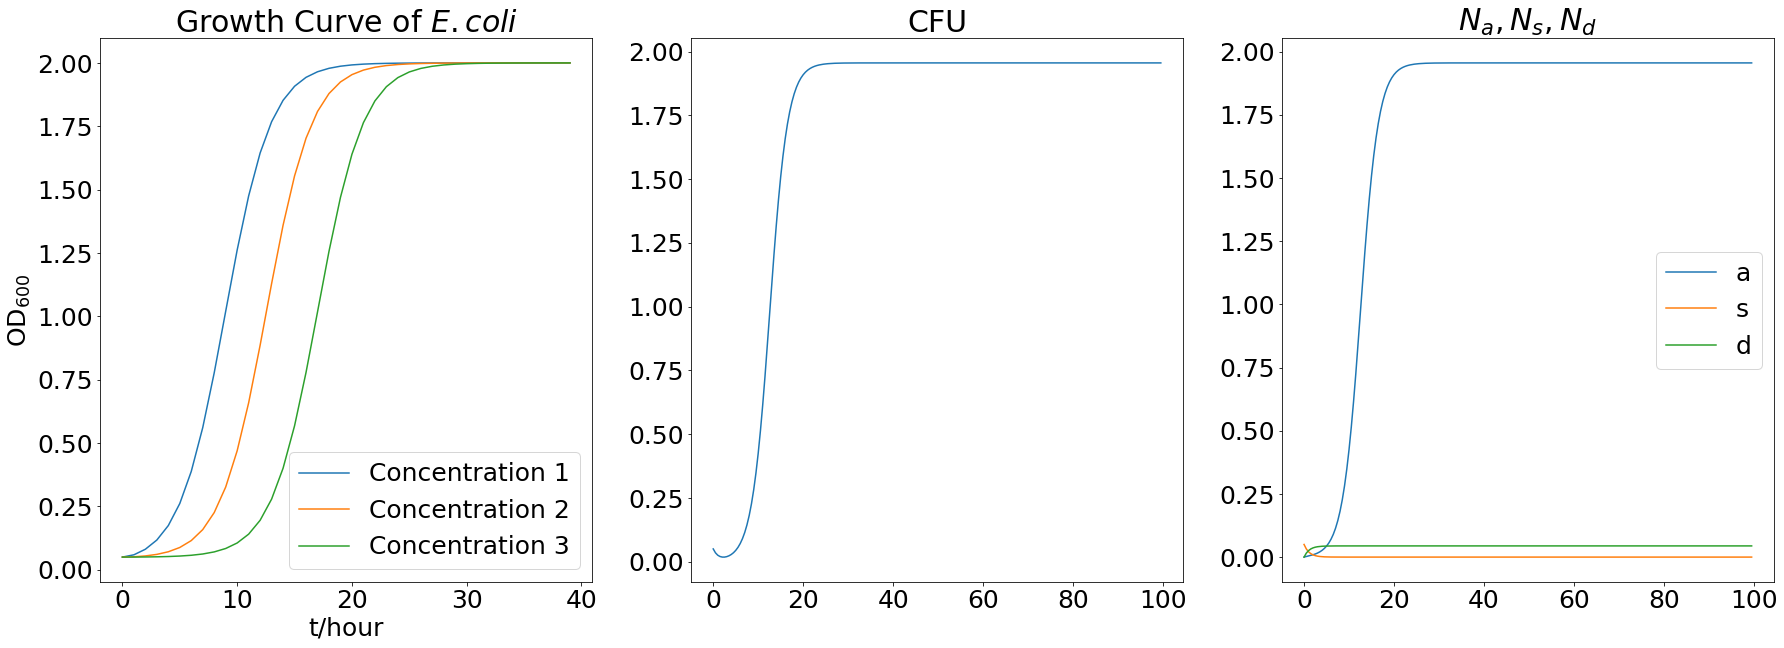

In [6]:
# 文献验证
Na0,Ns0,Nd0 = (0,0.05,0)
alpha = 0.77
beta = 1e-1
A = 2.0
k0 = 0.5
plt.rcParams.update({'font.size': 25})
t = np.arange(0,40,1)
t2 = np.arange(0,100,0.5)
plt.rcParams.update({'font.size': 25})
CFU = fit_CFU(t2,beta,k0,A,alpha)
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.title('Growth Curve of $\it{E. coli}$')
for i,b in enumerate([1,1e-1,1e-2]):
    fitted = fit_model_SAD(t,b,k0,A,alpha)
    od = np.sum(fitted,axis=1)
    plt.plot(t,od,label = 'Concentration '+str(i+1))
plt.xlabel('t/hour')
plt.ylabel('$\mathrm{OD}_{600}$')
plt.legend()
plt.subplot(132)
plt.title('CFU')
plt.plot(t2,CFU)
plt.subplot(133)
plt.title('$N_a,N_s,N_d$')
fitted = fit_model_SAD(t2,beta,k0,A,alpha)
plt.plot(t2,fitted[:,0],label = 'a')
plt.plot(t2,fitted[:,1],label = 's')
plt.plot(t2,fitted[:,2],label = 'd')


plt.legend()

In [7]:
def R_squared(Y,Y_fitted):
    mean = np.mean(Y)
    ss_tot = np.sum((Y - mean) ** 2)
    ss_res = np.sum((Y - Y_fitted) ** 2)
    r_squared = 1 - (ss_res / ss_tot) 
    return np.round(r_squared,3)

C:\Users\chenh\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([0.        , 0.49779272, 0.83820048, 0.        ]),
 array([[inf, inf, inf, inf],
        [inf, inf, inf, inf],
        [inf, inf, inf, inf],
        [inf, inf, inf, inf]]))

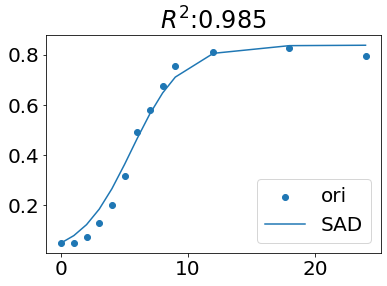

In [27]:
# 寻找k0，A
df_s_cont = df_s[df_s['treat'] == 0]
time_s = df_s_cont['time']
Na0,Ns0,Nd0 = (0.05,0,0)
popt,pcov = optimize.curve_fit(fit_od,time_s,df_s_cont['od'],p0=(0,0.5,0.8,0))
fitted_od = fit_od(time_s,*popt)
plt.scatter(time_s,df_s_cont['od'],label = 'ori')
plt.plot(time_s,fitted_od,label = 'SAD')
plt.legend()
plt.title('$R^2$:'+str(R_squared(df_s_cont['od'],fitted_od)))
popt,pcov  

beta and alpha with AgNP6.25 [ 5.06241243 27.77081004]
beta and alpha with AgNP12.5 [ 1.63464865 31.4354967 ]


C:\Users\chenh\AppData\Roaming\Python\Python38\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


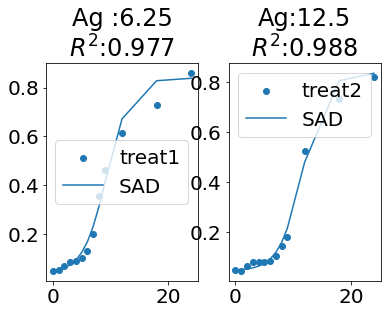

In [28]:
#寻找beta，alpha
def fit_od_by_a_b(t,beta,alpha):
    return fit_od(t = t,beta = beta,k0=0.4978,A=0.8382,alpha = alpha)
Na0,Ns0,Nd0 = (0,0.05,0)
treat1 = df_s[df_s['treat'] == 6.25]
treat2 = df_s[df_s['treat'] == 12.5]
popt1,pcov1 = optimize.curve_fit(fit_od_by_a_b,treat1['time'],treat1['od'])
fitted_od1 = fit_od_by_a_b(time_s,*popt1)
plt.subplot(121)
plt.title('Ag :6.25\n$R^2$:'+str(R_squared(treat1['od'],fitted_od1)))
plt.scatter(time_s,treat1['od'],label = 'treat1')
plt.plot(time_s,fitted_od1,label = 'SAD')
plt.legend()
print('beta and alpha with AgNP6.25',popt1)
popt2,pcov2 = optimize.curve_fit(fit_od_by_a_b,time_s,treat2['od'])
fitted_od2 = fit_od_by_a_b(time_s,*popt2)
plt.subplot(122)
plt.title('Ag:12.5\n$R^2$:'+str(R_squared(treat2['od'],fitted_od2)))
plt.scatter(time_s,treat2['od'],label = 'treat2')
plt.plot(time_s,fitted_od2,label = 'SAD')
plt.legend()
print('beta and alpha with AgNP12.5',popt2)

OD模型中alpha可能需要用CFU测定

beta with Ag 6.25 [0.2187025]
beta with Ag 12.5 [0.06179916]


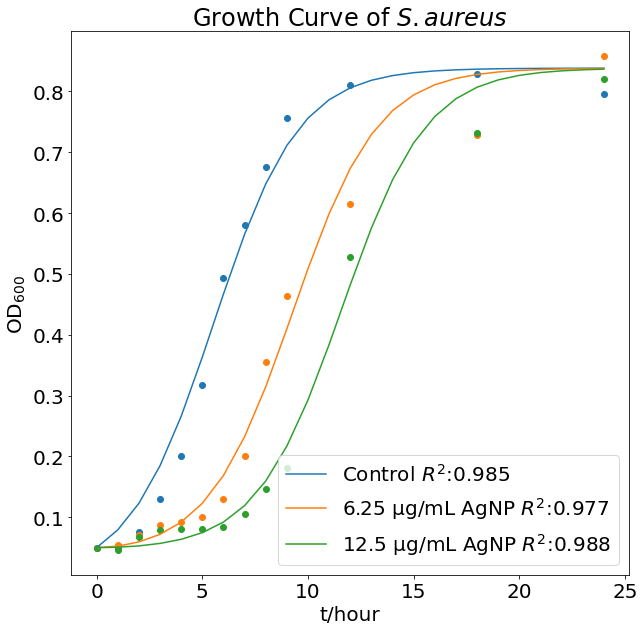

In [29]:
#使用alpha = 19.40
def fit_od_by_b(t,beta):
    global alpha
    return fit_od(t = t,beta = beta,k0=0.4978,A=0.8382,alpha = alpha)
alpha = 0.7
Na0,Ns0,Nd0 = (0.05,0,0)
plt.rcParams.update({'font.size': 20})
t = np.arange(0,25,1)
popt,pcov = optimize.curve_fit(fit_od,time_s,df_s_cont['od'],p0=(0,0.5,0.8,0))
fitted_od = fit_od(t,*popt)
plt.figure(figsize=(10,10))
plt.scatter(time_s,df_s_cont['od'])
plt.plot(t,fitted_od,label = 'Control $R^2$:'+str(R_squared(df_s_cont['od'],fit_od(time_s,*popt))))
Na0,Ns0,Nd0 = (0,0.05,0)
popt1,pcov1 = optimize.curve_fit(fit_od_by_b,treat1['time'],treat1['od'])
fitted_od1 = fit_od_by_b(t,*popt1)
plt.scatter(time_s,treat1['od'])
plt.plot(t,fitted_od1,label = '6.25 $ \mathrm{\mu g/mL}$ AgNP $R^2$:'+str(R_squared(treat1['od'],fit_od_by_b(time_s,*popt1))))
print('beta with Ag 6.25',popt1)
popt2,pcov2 = optimize.curve_fit(fit_od_by_b,time_s,treat2['od'])
fitted_od2 = fit_od_by_b(t,*popt2)
#plt.title('AgNP:12.5\n$R^2$:'+str(R_squared(treat2['od'],fitted_od2)))
plt.title('Growth Curve of $\it{S. aureus}$')
plt.scatter(time_s,treat2['od'])
plt.plot(t,fitted_od2,label = '12.5 $ \mathrm{\mu g/mL}$ AgNP $R^2$:'+str(R_squared(treat2['od'],fit_od_by_b(time_s,*popt2))))
plt.xlabel('t/hour')
plt.ylabel('$\mathrm{OD}_{600}$')
plt.legend()
print('beta with Ag 12.5',popt2)

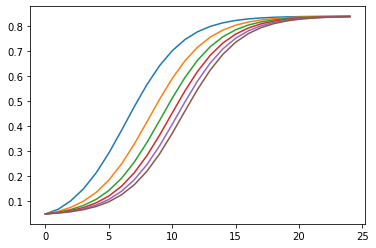

In [9]:

for a in np.arange(0,30,5):
    fitted_od = fit_od(np.arange(0,25,1),3.56,0.45,0.8382,a)
    plt.plot(np.arange(0,25,1),fitted_od)

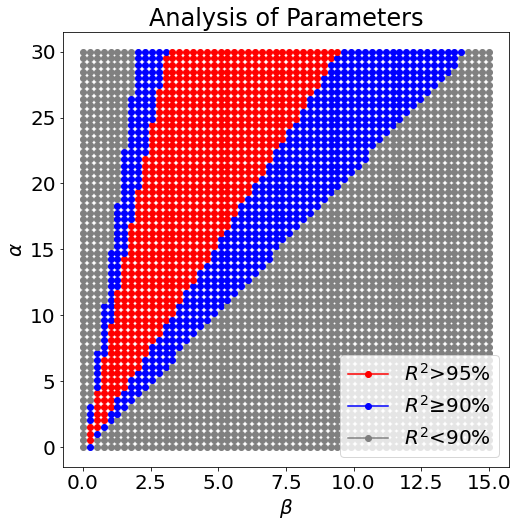

In [44]:
# 查看alpha 和 beta 关系
from itertools import product
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
plt.figure(figsize=(8,8))
#plt.subplot(121)
# for a in np.arange(0,30,1):
#     fitted_od = fit_od(time_s,3.56,0.45,0.8382,a)
#     plt.plot(time_s,fitted_od,color = 'blue')
# for b in np.arange(0,10,0.5):
#     fitted_od = fit_od(time_s,b,0.5,0.8,19)
#     plt.plot(time_s,fitted_od,color = 'red')
# plt.scatter(time_s,treat1['od'],color = 'black')
# plt.subplot(122)
scale = 60
beta = np.linspace(0,15,scale)
alpha = np.linspace(0,30,scale)

for b,a in product(beta,alpha):

    fitted = fit_od_by_a_b(time_s,b,a)
    r2 = R_squared(treat1['od'],fitted)
        
    if r2>0.95:
        color = 'red'
    elif 0.95>=r2>=0.9:
        color = 'blue'
    else:
        color = 'gray'
    plt.scatter(b,a,color = color)
plt.xlabel(r'$ \beta $')
plt.ylabel(r'$ \alpha $')
plt.title('Analysis of Parameters')
legend_elements = [Line2D([0], [0], marker='o',color = 'red', label='$R^2$>95%'),
                   Line2D([0], [0], marker='o',color='blue', label='$R^2$≥90%'),
                   Line2D([0], [0], marker='o',color='gray', label='$R^2$<90%'),]
plt.legend(handles=legend_elements,loc = 'lower right')

Text(0.5, 1.0, 'Logistic Growth Curve')

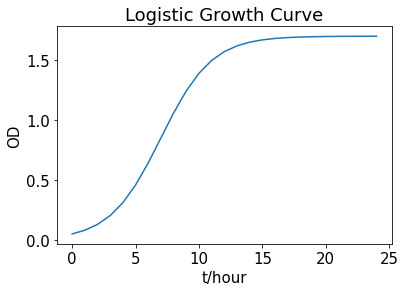

In [53]:
def model_logistic(I,t,k0,A):
    N= I
    dN = k0*(1-N/A)*N
    return dN
def fit_model_logistic(t,k0,A):
    return odeint(model_logistic,N0,t,args=(k0,A))
N0 = 0.05
k0 = 0.5
A = 1.7
t = np.arange(0,25,1)
res  = fit_model_logistic(t,k0,A)[:,0]
plt.rcParams.update({'font.size': 15})
plt.plot(t,res)
plt.xlabel('t/hour')
plt.ylabel('OD')
plt.title('Logistic Growth Curve')



d:\APP\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:161: RuntimeWarning: invalid value encountered in double_scalars
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
d:\APP\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:161: RuntimeWarning: invalid value encountered in divide
  return np.mean(B * (AB - A), axis=0) / np.var(np.r_[A, B], axis=0)
d:\APP\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:169: RuntimeWarning: invalid value encountered in double_scalars
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
d:\APP\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:169: RuntimeWarning: invalid value encountered in divide
  return 0.5 * np.mean((A - AB) ** 2, axis=0) / np.var(np.r_[A, B], axis=0)
d:\APP\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:174: RuntimeWarning: invalid value encountered in double_scalars
  Vjk = np.mean(BAj * ABk - A * B, axis=0) / np.var(np.r_[A, B], axis=0)
d:\APP\Anaconda3\lib\site-packages\SAL

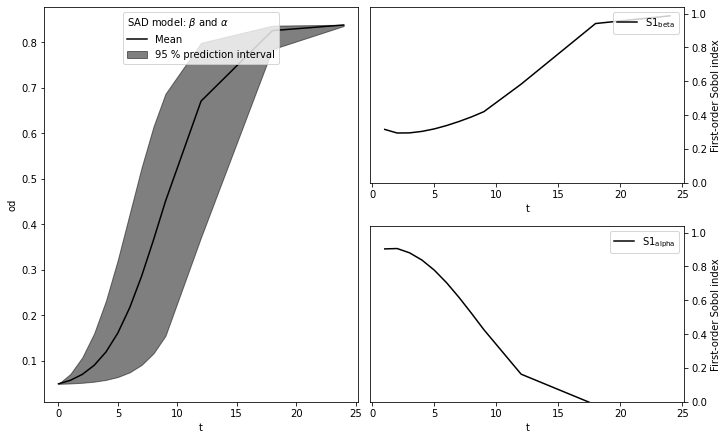

In [38]:
#敏感度分析
from SALib.analyze import sobol
from SALib.sample import saltelli
# https://salib.readthedocs.io/en/latest/basics.html
problem = {
    'num_vars': 2,
    'names': ['beta', 'alpha'],
    'bounds': [[0, 10],
               [0, 40]]
}
param_values = saltelli.sample(problem, 2^10)

y = np.array([fit_od_by_a_b(time_s, *params) for params in param_values])

sobol_indices = [sobol.analyze(problem, Y) for Y in y.T]
S1s = np.array([s['S1'] for s in sobol_indices])
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(2, 2)
ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 1])

for i, ax in enumerate([ax1, ax2]):
    ax.plot(time_s, S1s[:, i],
            label=r'S1$_\mathregular{{{}}}$'.format(problem["names"][i]),
            color='black')
    ax.set_xlabel("t")
    ax.set_ylabel("First-order Sobol index")

    ax.set_ylim(0, 1.04)

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    ax.legend(loc='upper right')

ax0.plot(time_s, np.mean(y, axis=0), label="Mean", color='black')

# in percent
prediction_interval = 95

ax0.fill_between(time_s,
                 np.percentile(y, 50 - prediction_interval/2., axis=0),
                 np.percentile(y, 50 + prediction_interval/2., axis=0),
                 alpha=0.5, color='black',
                 label=f"{prediction_interval} % prediction interval")

ax0.set_xlabel("t")
ax0.set_ylabel("od")
ax0.legend(title=r"SAD model: $\beta$ and $\alpha$",
           loc='upper center')._legend_box.align = "left"


C:\Users\chenh\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


array([0.        , 1.04647426, 1.70797771, 0.        ])

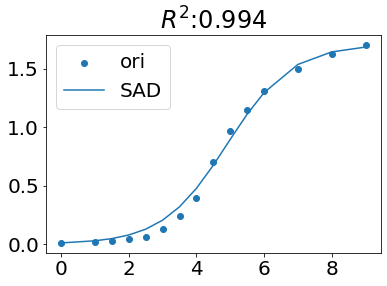

In [14]:
# 寻找k0，A
df_e_cont = df_e[df_e['treat'] == 0]
time_e = df_e_cont['time']
Na0,Ns0,Nd0 = (0.01,0,0)
popt,pcov = optimize.curve_fit(fit_od,time_e,df_e_cont['number'],p0=(0,1,1.8,0))
fitted_CFU = fit_CFU(time_e,*popt)
plt.scatter(time_e,df_e_cont['number'],label = 'ori')
plt.plot(time_e,fitted_CFU,label = 'SAD')
plt.legend()
plt.title('$R^2$:'+str(R_squared(df_e_cont['number'],fitted_CFU)))
popt

beta and alpha with AgNP:10 [57.19318122 10.85899517]
beta and alpha with AgNP:50 [48.55928325 30.98901976]
beta and alpha with AgNP:100 [ 26.15601144 211.62963421]


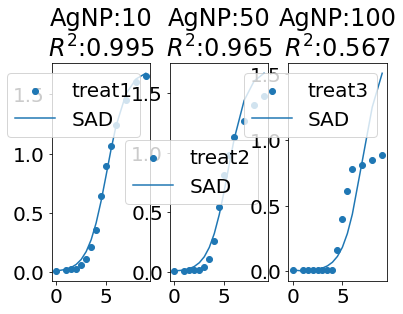

In [15]:
#寻找beta，alpha
def fit_CFU_by_a_b(t,beta,alpha):
    return fit_CFU(t = t,beta = beta,k0=1.04657426,A=1.7079777,alpha = alpha)
Na0,Ns0,Nd0 = (0,0.01,0)
treat1 = df_e[df_e['treat'] == 10]
treat2 = df_e[df_e['treat'] == 50]
treat3 = df_e[df_e['treat'] == 100]
popt1,pcov1 = optimize.curve_fit(fit_CFU_by_a_b,time_e,treat1['number'])
fitted_CFU1 = fit_CFU_by_a_b(time_e,*popt1)
plt.subplot(131)
plt.title('AgNP:10\n$R^2$:'+str(R_squared(treat1['number'],fitted_CFU1)))
plt.scatter(time_e,treat1['number'],label = 'treat1')
plt.plot(time_e,fitted_CFU1,label = 'SAD')
plt.legend()
print('beta and alpha with AgNP:10',popt1)
popt2,pcov2 = optimize.curve_fit(fit_CFU_by_a_b,time_e,treat2['number'])
fitted_CFU2 = fit_CFU_by_a_b(time_e,*popt2)
plt.subplot(132)
plt.title('AgNP:50\n$R^2$:'+str(R_squared(treat2['number'],fitted_CFU2)))
plt.scatter(time_e,treat2['number'],label = 'treat2')
plt.plot(time_e,fitted_CFU2,label = 'SAD')
plt.legend()
print('beta and alpha with AgNP:50',popt2)
popt3,pcov3 = optimize.curve_fit(fit_CFU_by_a_b,time_e,treat3['number'])
fitted_CFU3 = fit_CFU_by_a_b(time_e,*popt3)
plt.subplot(133)
plt.title('AgNP:100\n$R^2$:'+str(R_squared(treat3['number'],fitted_CFU3)))
plt.scatter(time_e,treat3['number'],label = 'treat3')
plt.plot(time_e,fitted_CFU3,label = 'SAD')
plt.legend()
print('beta and alpha with AgNP:100',popt3)


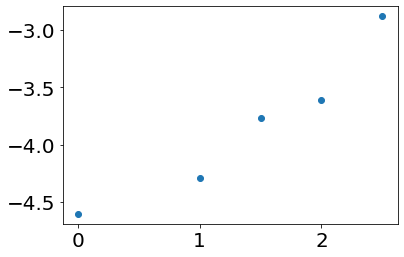

In [16]:
#通过CFU计算alpha，这份数据不是很明显
plt.scatter(time_e[0:5],np.log(treat1['number'][0:5]))

beta and alpha with AgNP:10 [8.71159206]
beta and alpha with AgNP:50 [2.73864099]
beta and alpha with AgNP:100 [0.19510885]


C:\Users\chenh\AppData\Roaming\Python\Python38\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


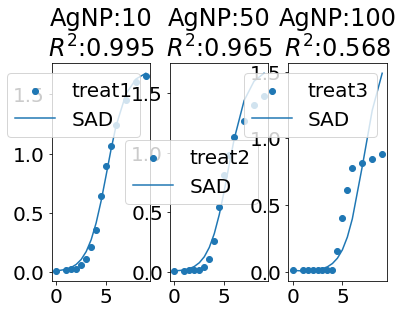

In [17]:
#寻找beta
alpha = 0.77
def fit_CFU_by_b(t,beta):
    global alpha
    return fit_CFU(t = t,beta = beta,k0=1.04657426,A=1.7079777,alpha = alpha)
Na0,Ns0,Nd0 = (0,0.01,0)
treat1 = df_e[df_e['treat'] == 10]
treat2 = df_e[df_e['treat'] == 50]
treat3 = df_e[df_e['treat'] == 100]
popt1,pcov1 = optimize.curve_fit(fit_CFU_by_b,time_e,treat1['number'])
fitted_CFU1 = fit_CFU_by_b(time_e,*popt1)
plt.subplot(131)
plt.title('AgNP:10\n$R^2$:'+str(R_squared(treat1['number'],fitted_CFU1)))
plt.scatter(time_e,treat1['number'],label = 'treat1')
plt.plot(time_e,fitted_CFU1,label = 'SAD')
plt.legend()
print('beta and alpha with AgNP:10',popt1)
popt2,pcov2 = optimize.curve_fit(fit_CFU_by_b,time_e,treat2['number'])
fitted_CFU2 = fit_CFU_by_b(time_e,*popt2)
plt.subplot(132)
plt.title('AgNP:50\n$R^2$:'+str(R_squared(treat2['number'],fitted_CFU2)))
plt.scatter(time_e,treat2['number'],label = 'treat2')
plt.plot(time_e,fitted_CFU2,label = 'SAD')
plt.legend()
print('beta and alpha with AgNP:50',popt2)
popt3,pcov3 = optimize.curve_fit(fit_CFU_by_b,time_e,treat3['number'])
fitted_CFU3 = fit_CFU_by_b(time_e,*popt3)
plt.subplot(133)
plt.title('AgNP:100\n$R^2$:'+str(R_squared(treat3['number'],fitted_CFU3)))
plt.scatter(time_e,treat3['number'],label = 'treat3')
plt.plot(time_e,fitted_CFU3,label = 'SAD')
plt.legend()
print('beta and alpha with AgNP:100',popt3)

AgNP:100 [5.60801524e-04 2.57358774e+00 8.58377163e-01 5.93992430e-01]


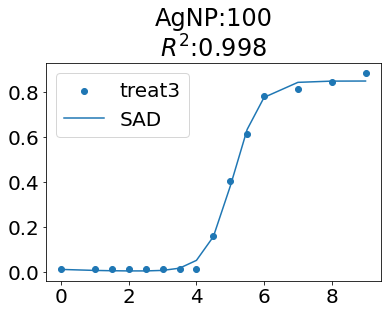

In [18]:
popt3,pcov3 = optimize.curve_fit(fit_CFU,time_e,treat3['number'])
fitted_CFU3 = fit_CFU(time_e,*popt3)
plt.title('AgNP:100\n$R^2$:'+str(R_squared(treat3['number'],fitted_CFU3)))
plt.scatter(time_e,treat3['number'],label = 'treat3')
plt.plot(time_e,fitted_CFU3,label = 'SAD')
plt.legend()
print('AgNP:100',popt3)

In [19]:
problem = {
    'num_vars': 2,
    'names': ['beta', 'alpha'],
    'bounds': [[0, 100],
               [0, 200]]
}
param_values = saltelli.sample(problem, 2^12)

y = np.array([fit_CFU_by_a_b(time_e, *params) for params in param_values])

sobol_indices = [sobol.analyze(problem, Y) for Y in y.T]
S1s = np.array([s['S1'] for s in sobol_indices])
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(2, 2)
ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 1])

for i, ax in enumerate([ax1, ax2]):
    ax.plot(time_e, S1s[:, i],
            label=r'S1$_\mathregular{{{}}}$'.format(problem["names"][i]),
            color='black')
    ax.set_xlabel("t")
    ax.set_ylabel("First-order Sobol index")

    ax.set_ylim(0, 1.04)

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    ax.legend(loc='upper right')

ax0.plot(time_e, np.mean(y, axis=0), label="Mean", color='black')

# in percent
prediction_interval = 95

ax0.fill_between(time_e,
                 np.percentile(y, 50 - prediction_interval/2., axis=0),
                 np.percentile(y, 50 + prediction_interval/2., axis=0),
                 alpha=0.5, color='black',
                 label=f"{prediction_interval} % prediction interval")

ax0.set_xlabel("t")
ax0.set_ylabel("number")
ax0.legend(title=r"SAD model: $\beta$ and $\alpha$",
           loc='upper center')._legend_box.align = "left"

NameError: name 'saltelli' is not defined

[0.         0.45702088 0.93939166 0.        ] [ 0.02174867  0.45055636  0.88034695 -0.31570869]


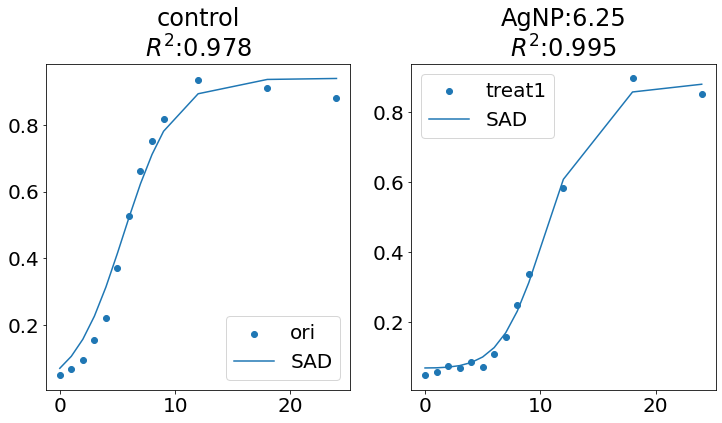

In [20]:
#Ecoli OD
df_eo_cont = df_eo[df_eo['treat'] == 0]
treat1 = df_eo[df_eo['treat'] == 6.25]
time_eo = time_s
Na0,Ns0,Nd0 = (0.07,0,0)
popt1,pcov1 = optimize.curve_fit(fit_od,time_eo,df_eo_cont['od'],p0 = (0,0.45,0.9,0))
fitted_od1 = fit_od(time_eo,*popt1)
Na0,Ns0,Nd0 = (0,0.07,0)
popt2,pcov2 = optimize.curve_fit(fit_od,time_eo,treat1['od'],p0 = (1,0.45,0.9,1))
fitted_od2 = fit_od(time_eo,*popt2)
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('control\n$R^2$:'+str(R_squared(df_eo_cont['od'],fitted_od1)))
plt.scatter(time_eo,df_eo_cont['od'],label = 'ori')
plt.plot(time_eo,fitted_od1,label = 'SAD')
plt.legend()
plt.subplot(122)
plt.title('AgNP:6.25\n$R^2$:'+str(R_squared(treat1['od'],fitted_od2)))
plt.scatter(time_eo,treat1['od'],label = 'treat1')
plt.plot(time_eo,fitted_od2,label = 'SAD')
plt.legend()
print(popt1,popt2)

C:\Users\chenh\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(array([0.        , 0.74720263, 1.18188574, 0.        ]),
 array([[inf, inf, inf, inf],
        [inf, inf, inf, inf],
        [inf, inf, inf, inf],
        [inf, inf, inf, inf]]))

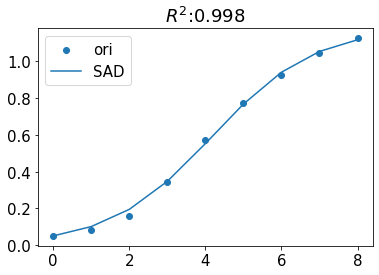

In [55]:
df_w = pd.read_csv('./shewanella.csv')
df_w_cont = df_w[df_w['treat'] == 0]
time_w = df_w_cont['time']
Na0,Ns0,Nd0 = (0.05,0,0)
popt,pcov = optimize.curve_fit(fit_od,time_w,df_w_cont['od'],p0=(0,0.5,0.8,0))
fitted_od = fit_od(time_w,*popt)
plt.scatter(time_w,df_w_cont['od'],label = 'ori')
plt.plot(time_w,fitted_od,label = 'SAD')
plt.legend()
plt.title('$R^2$:'+str(R_squared(df_w_cont['od'],fitted_od)))
popt,pcov

C:\Users\chenh\AppData\Roaming\Python\Python38\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


beta and alpha with Ag 5 [ 1.45034334 -0.79216796]
beta and alpha with Ag:7 [0.4987636  0.20952515]
beta and alpha with Ag:10 [ 0.03447398 -0.54636613]


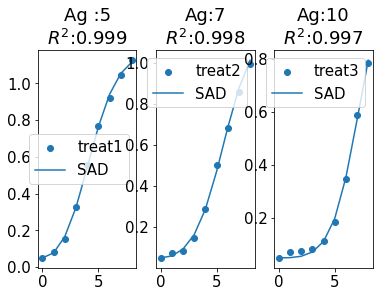

In [56]:
def fit_od_by_a_b(t,beta, alpha):
    return fit_od(t = t,beta = beta,k0=0.7472,A=1.18,alpha = alpha)
def fit_od_by_b(t,beta):
    return fit_od(t = t,beta = beta,k0=0.7472,A=1.18,alpha = 0.7)
Na0,Ns0,Nd0 = (0,0.05,0)
treat1 = df_w[df_w['treat'] == 5]
treat2 = df_w[df_w['treat'] == 7]
treat3 = df_w[df_w['treat'] == 10]
popt1,pcov1 = optimize.curve_fit(fit_od_by_a_b,treat1['time'],treat1['od'])
fitted_od1 = fit_od_by_a_b(time_w,*popt1)
plt.subplot(131)
plt.title('Ag :5\n$R^2$:'+str(R_squared(treat1['od'],fitted_od1)))
plt.scatter(time_w,treat1['od'],label = 'treat1')
plt.plot(time_w,fitted_od1,label = 'SAD')
plt.legend()
print('beta and alpha with Ag 5',popt1)
popt2,pcov2 = optimize.curve_fit(fit_od_by_a_b,time_w,treat2['od'])
fitted_od2 = fit_od_by_a_b(time_w,*popt2)
plt.subplot(132)
plt.title('Ag:7\n$R^2$:'+str(R_squared(treat2['od'],fitted_od2)))
plt.scatter(time_w,treat2['od'],label = 'treat2')
plt.plot(time_w,fitted_od2,label = 'SAD')
plt.legend()
print('beta and alpha with Ag:7',popt2)
popt3,pcov3 = optimize.curve_fit(fit_od_by_a_b,time_w,treat3['od'])
fitted_od3 = fit_od_by_a_b(time_w,*popt3)
plt.subplot(133)
plt.title('Ag:10\n$R^2$:'+str(R_squared(treat3['od'],fitted_od3)))
plt.scatter(time_w,treat3['od'],label = 'treat3')
plt.plot(time_w,fitted_od3,label = 'SAD')
plt.legend()
print('beta and alpha with Ag:10',popt3)

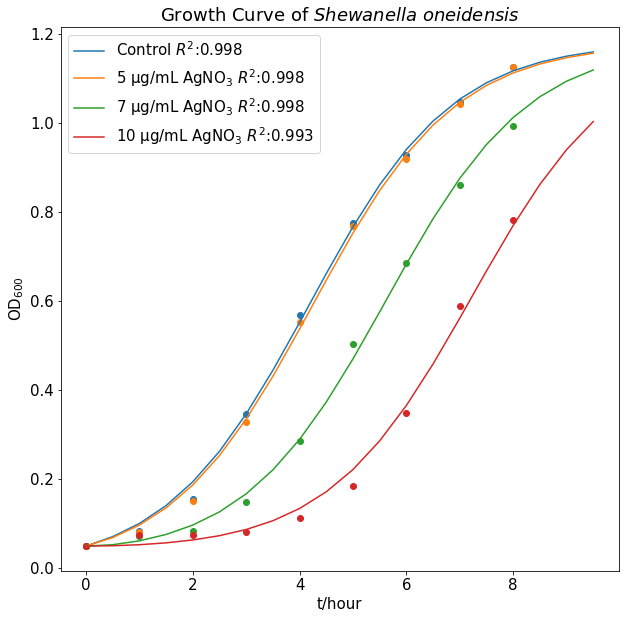

In [57]:
alpha = 1
Na0,Ns0,Nd0 = (0.05,0,0)
t = np.arange(0,10,0.5)
popt,pcov = optimize.curve_fit(fit_od,time_w,df_w_cont['od'],p0=(0,0.5,0.8,0))
fitted_od = fit_od(t,*popt)
plt.figure(figsize=(10,10))
plt.scatter(time_w,df_w_cont['od'])
plt.plot(t,fitted_od,label = 'Control $R^2$:'+str(R_squared(df_w_cont['od'],fit_od(time_w,*popt))))

Na0,Ns0,Nd0 = (0,0.05,0)
popt1,pcov1 = optimize.curve_fit(fit_od_by_b,treat1['time'],treat1['od'])
fitted_od1 = fit_od_by_b(t,*popt1)
plt.scatter(time_w,treat1['od'])
plt.plot(t,fitted_od1,label = '5 $ \mathrm{\mu g/mL}$ $\mathrm{AgNO_3}$ $R^2$:'+str(R_squared(treat1['od'],fit_od_by_b(time_w,*popt1))))

popt2,pcov2 = optimize.curve_fit(fit_od_by_b,time_w,treat2['od'])
fitted_od2 = fit_od_by_b(t,*popt2)
#plt.title('AgNP:12.5\n$R^2$:'+str(R_squared(treat2['od'],fitted_od2)))
plt.title('Growth Curve of $\it{Shewanella}$ $\it{oneidensis}$')
plt.scatter(time_w,treat2['od'])
plt.plot(t,fitted_od2,label = '7 $ \mathrm{\mu g/mL}$ $\mathrm{AgNO_3}$ $R^2$:'+str(R_squared(treat2['od'],fit_od_by_b(time_w,*popt2))))

popt3,pcov3 = optimize.curve_fit(fit_od_by_b,treat3['time'],treat3['od'])
fitted_od3 = fit_od_by_b(t,*popt3)
plt.scatter(time_w,treat3['od'])
plt.plot(t,fitted_od3,label = '10 $ \mathrm{\mu g/mL}$ $\mathrm{AgNO_3}$ $R^2$:'+str(R_squared(treat3['od'],fit_od_by_b(time_w,*popt3))))
plt.xlabel('t/hour')
plt.ylabel('$\mathrm{OD}_{600}$')
plt.legend()

beta and alpha with Ag 5 [26.44647693]
beta and alpha with Ag:7 [0.88519155]
beta and alpha with Ag:10 [0.19752685]


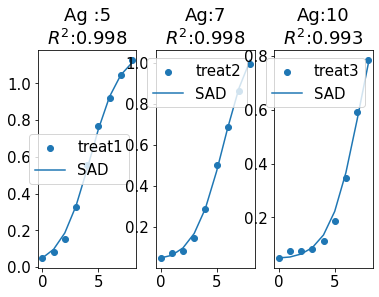

In [58]:
def fit_od_by_a_b(t,beta):
    return fit_od(t = t,beta = beta,k0=0.7472,A=1.18,alpha = 1)
Na0,Ns0,Nd0 = (0,0.05,0)
treat1 = df_w[df_w['treat'] == 5]
treat2 = df_w[df_w['treat'] == 7]
treat3 = df_w[df_w['treat'] == 10]
popt1,pcov1 = optimize.curve_fit(fit_od_by_a_b,treat1['time'],treat1['od'])
fitted_od1 = fit_od_by_a_b(time_w,*popt1)
plt.subplot(131)
plt.title('Ag :5\n$R^2$:'+str(R_squared(treat1['od'],fitted_od1)))
plt.scatter(time_w,treat1['od'],label = 'treat1')
plt.plot(time_w,fitted_od1,label = 'SAD')
plt.legend()
print('beta and alpha with Ag 5',popt1)
popt2,pcov2 = optimize.curve_fit(fit_od_by_a_b,time_w,treat2['od'])
fitted_od2 = fit_od_by_a_b(time_w,*popt2)
plt.subplot(132)
plt.title('Ag:7\n$R^2$:'+str(R_squared(treat2['od'],fitted_od2)))
plt.scatter(time_w,treat2['od'],label = 'treat2')
plt.plot(time_w,fitted_od2,label = 'SAD')
plt.legend()
print('beta and alpha with Ag:7',popt2)
popt3,pcov3 = optimize.curve_fit(fit_od_by_a_b,time_w,treat3['od'])
fitted_od3 = fit_od_by_a_b(time_w,*popt3)
plt.subplot(133)
plt.title('Ag:10\n$R^2$:'+str(R_squared(treat3['od'],fitted_od3)))
plt.scatter(time_w,treat3['od'],label = 'treat3')
plt.plot(time_w,fitted_od3,label = 'SAD')
plt.legend()
print('beta and alpha with Ag:10',popt3)

(array([-0.94155146,  7.41514105]), 3)

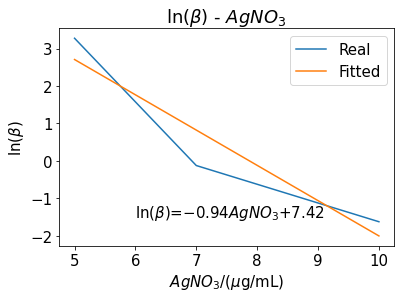

In [81]:
beta_set = np.array([popt1[0],popt2[0],popt3[0]])
ag_set = np.array([5,7,10])
plt.plot(ag_set,np.log(beta_set),label='Real')
def line(p):
    k,b = p
    return np.log(beta_set) - k*ag_set-b
fit_line = optimize.leastsq(line,[-1,3])
k,b = fit_line[0]
plt.plot(ag_set,k*ag_set+b,label='Fitted')
plt.legend()
plt.title(r'ln($\beta$) - $AgNO_3$ ')
plt.ylabel(r'ln($\beta$)')
plt.xlabel(r'$AgNO_3$/$(\mu$g/mL)')
plt.annotate(r'ln($\beta$)=$-$0.94$AgNO_3$+7.42',(6,-1.5))
fit_line 

In [ ]:
#模拟
